In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)

sns.set(style="whitegrid")

In [2]:
# Load Dataset and Split
# Load preprocessed data
df = pd.read_csv("../data/preprocessed_data.csv")

# Split into features and target
X = df.drop("Revenue", axis=1)
y = df["Revenue"].astype(int)

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Class distribution in training set: \n{y_train.value_counts(normalize=True)}")

Train size: 9864, Test size: 2466
Class distribution in training set: 
Revenue
0    0.845296
1    0.154704
Name: proportion, dtype: float64


In [3]:
# Random Forest + SMOTE + GridSearch
rf_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(random_state=42))
])

rf_params = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [5, 10, None],
    "rf__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid=rf_params,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
rf_best = grid_rf.best_estimator_
print("Best Random Forest parameters:", grid_rf.best_params_)

Best Random Forest parameters: {'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


In [4]:
# XGBoost + SMOTE + GridSearch
xgb_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

xgb_params = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5, 8],
    "xgb__learning_rate": [0.01, 0.1, 0.3]
}

grid_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=xgb_params,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
xgb_best = grid_xgb.best_estimator_
print("Best XGBoost parameters:", grid_xgb.best_params_)

/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:26:49] WARNING: /Users/runner/work/

Best XGBoost parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}


In [5]:
# Evaluation Function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"------ {name} ------")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Greens")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

------ Random Forest (SMOTE) ------
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2084
           1       0.62      0.70      0.66       382

    accuracy                           0.89      2466
   macro avg       0.78      0.81      0.80      2466
weighted avg       0.89      0.89      0.89      2466

F1 Score: 0.6584463625154131
Precision: 0.6223776223776224
Recall: 0.6989528795811518
ROC AUC: 0.9211418838118399


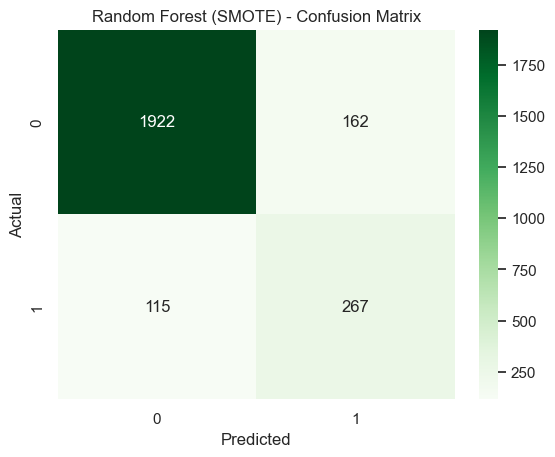

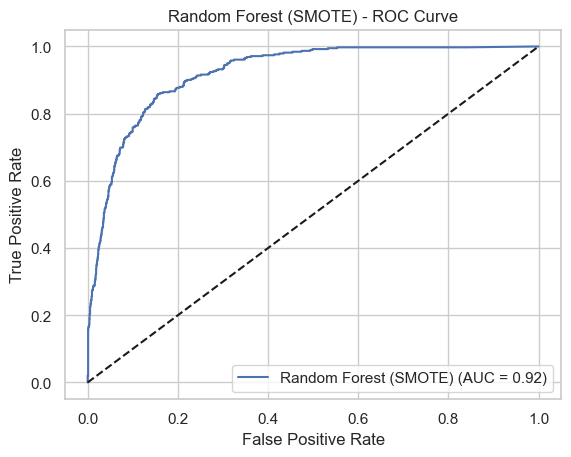

------ XGBoost (SMOTE) ------
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      2084
           1       0.64      0.67      0.66       382

    accuracy                           0.89      2466
   macro avg       0.79      0.80      0.80      2466
weighted avg       0.89      0.89      0.89      2466

F1 Score: 0.6572528883183568
Precision: 0.6448362720403022
Recall: 0.6701570680628273
ROC AUC: 0.925685979439459


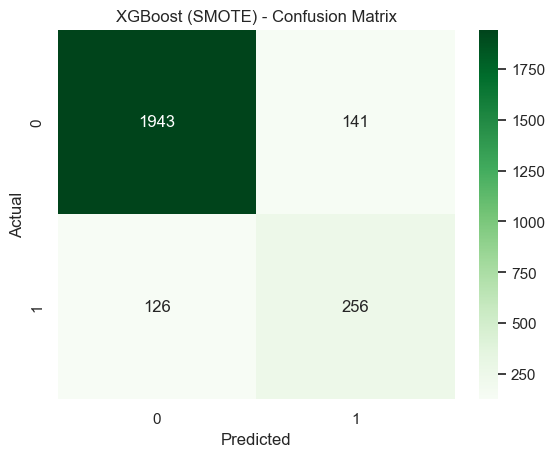

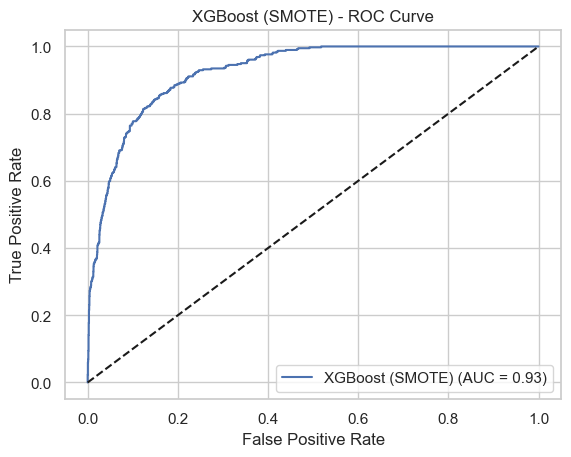

In [6]:
# Run Evaluation
evaluate_model("Random Forest (SMOTE)", rf_best, X_test, y_test)
evaluate_model("XGBoost (SMOTE)", xgb_best, X_test, y_test)

In [7]:
import joblib

# Random Forest
joblib.dump(rf_best, "../models/rf.pkl")

# XGBoost
joblib.dump(xgb_best, "../models/xgb.pkl")

['../models/xgb.pkl']

In [8]:
def evaluate_train_test_split(model, X_train, y_train, X_test, y_test, name="Model"):
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

    for label, X, y in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1]
        print(f"🔹 {name} - {label} Set:")
        print(f"   F1 Score     : {f1_score(y, y_pred):.3f}")
        print(f"   Precision    : {precision_score(y, y_pred):.3f}")
        print(f"   Recall       : {recall_score(y, y_pred):.3f}")
        print(f"   ROC AUC      : {roc_auc_score(y, y_proba):.3f}\n")

evaluate_train_test_split(rf_best, X_train, y_train, X_test, y_test, name="Random Forest")
evaluate_train_test_split(xgb_best, X_train, y_train, X_test, y_test, name="XGBoost")

🔹 Random Forest - Train Set:
   F1 Score     : 0.979
   Precision    : 0.980
   Recall       : 0.978
   ROC AUC      : 1.000

🔹 Random Forest - Test Set:
   F1 Score     : 0.658
   Precision    : 0.622
   Recall       : 0.699
   ROC AUC      : 0.921

🔹 XGBoost - Train Set:
   F1 Score     : 0.764
   Precision    : 0.746
   Recall       : 0.784
   ROC AUC      : 0.962

🔹 XGBoost - Test Set:
   F1 Score     : 0.657
   Precision    : 0.645
   Recall       : 0.670
   ROC AUC      : 0.926
